# Optimization Framework using auto-diff to predict binding rates


## Import the necessary modules

In [1]:
# make sure jupyter path is correct for loading local moudules
import sys
# path to steric_simulator module relative to notebook
sys.path.append("../../../")
import copy

In [2]:
from KineticAssembly_AD import ReactionNetwork, VectorizedRxnNet, VecSim, Optimizer, EquilibriumSolver

EnergyExplorer Module is not available. Check Rosetta installation. <ipykernel.iostream.OutStream object at 0x7faa0c59df90>


## Setup the Reaction Network

In [3]:
base_input = '../input_files/trimer.pwr'
rn = ReactionNetwork(base_input, one_step=True)
rn.resolve_tree()


['default_assoc', 1.0]
['A']
100.0
['B']
100.0
['C']
100.0
Parsing rule...
SPLIT_01:  ['A(a)+B(a)', 'A(a!1).B(a!1)']
['A', 'B', '']
GGGGGGGGGgg
Parsing rule...
SPLIT_01:  ['A(b)+C(b)', 'A(b!1).C(b!1)']
['A', 'C', '']
GGGGGGGGGgg
Parsing rule...
SPLIT_01:  ['B(b)+C(a)', 'B(b!1).C(a!1)']
['B', 'C', '']
GGGGGGGGGgg
Node-1 :  (0, {'struct': <networkx.classes.graph.Graph object at 0x7fa9348f5850>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1})
Node-2 :  (0, {'struct': <networkx.classes.graph.Graph object at 0x7fa9348f5850>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1})
-----
{'A'}
{'A'}
set()
Steric hindrance detected
Node-1 :  (0, {'struct': <networkx.classes.graph.Graph object at 0x7fa9348f5850>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1})
Node-2 :  (1, {'struct': <networkx.classes.graph.Graph object at 0x7fa9348f5a50>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1})
-----
{'A'}
{'B'}
{'A'}
False
Orig edges:  []
Nextn edge

In [4]:
uid_dict = {}
sys.path.append("../../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    #print(n)
    #print(rn.network.nodes()[n])
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_dict[(n,k)] = uid

print(uid_dict)

{(0, 3): 0, (0, 4): 1, (0, 6): 5, (1, 3): 0, (1, 5): 2, (1, 6): 3, (2, 4): 1, (2, 5): 2, (2, 6): 4, (3, 6): 4, (4, 6): 3, (5, 6): 5}


## Set the initial parameter values 
For a hetero-trimer there are 6 reaction rates.
Also defines the Vectorized Rxn NEt class

In [5]:
#Changing Initial Conditions
import networkx as nx
#Changin k_on
new_kon = [1,1,1,1,1,1]*np.array([1e0])  

update_kon_dict = {}
for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))
    update_kon_dict[edge] = new_kon[uid_dict[edge]]

nx.set_edge_attributes(rn.network,update_kon_dict,'k_on')

# for edge in rn.network.edges:
#     print(rn.network.get_edge_data(edge[0],edge[1]))
vec_rn = VectorizedRxnNet(rn, dev='cpu',coupling=True,cid={0:4})
print(vec_rn.kon)

{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-8.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-8.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-16.], dtype=torch.float64), 'uid': 5}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-8.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-8.], dtype=torch.float64), 'uid': 2}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-16.], dtype=torch.float64), 'uid': 3}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-8.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-8.], dtype=torch.float64), 'uid': 2}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-16.], dtype=torch.float64), 'uid': 4}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-16.], dtype=torch.float64), 'uid': 4}
{'k_on': 1.0, 'k

In [6]:
uid_dict = {}
sys.path.append("../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    #print(n)
    #print(rn.network.nodes()[n])
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_val = {'reactants':reactants,'kon':v['k_on'],'score':v['rxn_score'],'koff':v['k_off'],'uid':uid}
        if uid not in uid_dict.keys():
            uid_dict[uid] = uid_val
    print(gtostr(rn.network.nodes[n]['struct']))
    #for r_set in rn.get_reactant_sets(n):
    #    print(tuple(r_set))
    #print(rn.network[n]['struct'])
ind_sort = np.argsort(vec_rn.kon.detach().numpy())
for i in ind_sort:
    print(vec_rn.kon[i])
    print(uid_dict[i])

A
B
C
AB
AC
BC
ABC
tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'A'}, {'B'}), 'kon': 1.0, 'score': tensor([-8.], dtype=torch.float64), 'koff': None, 'uid': 0}
tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'A'}, {'C'}), 'kon': 1.0, 'score': tensor([-8.], dtype=torch.float64), 'koff': None, 'uid': 1}
tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'B'}, {'C'}), 'kon': 1.0, 'score': tensor([-8.], dtype=torch.float64), 'koff': None, 'uid': 2}
tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'B'}, {'C', 'A'}), 'kon': 1.0, 'score': tensor([-16.], dtype=torch.float64), 'koff': None, 'uid': 3}
tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'C'}, {'A', 'B'}), 'kon': 1.0, 'score': tensor([-16.], dtype=torch.float64), 'koff': None, 'uid': 4}
tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'A'}, {'C', 'B'}), 'kon': 1.0, 'score': tensor([-1

## Using the optimizer ##

### Define an instance of the optimizer class
#### Input Arguments:

reaction_network : Input the vectorized rxn network

sim_runtime: The runtime of the kinetic simulation. Needs to be same as the time over the experimental reaction data.

optim_iterations: No. of iterations to run the optimization. Can start at low values(100) and increase depending upon memory usage.

learning_rate = The size of the gradient descent step for updating parameter values. Needs to be atleast (1e-3-1e-1)* min{parameter value}. If learning rate is too high, it can take a longer step and sometimes lead to negative value of parameters which is unphysical. Requires some trial runs to find the best value. 

device: cpu or gpu

method: Choose which pytorch based optimized to use for gradient descent - Adam or RMSprop

mom: Only for RMSprop method. Use momentum term during gradient descent. 


In [7]:
vec_rn.reset(reset_params=True)
optim = Optimizer(reaction_network=vec_rn,
                  sim_runtime=0.2,
                  optim_iterations=10,
                  learning_rate=1e-2,
                  device='cpu',method="RMSprop",mom=0.9)


Using CPU


### Call the optimization method

#### Input arguments

conc_scale, conc_thresh, mod_bool, mod_factor, yield_species = As defined for the VecSim class. 

max_thresh: Max. allowed values of parameters being updated. Beyond this maximum a penalty is imposed on the cost function. (Regularization)

max_yield: It is a control variable that is used to store the updated parameter values over all iterations for further analysis. The parameter values are stored only if the current yield exceed this max_yield. 

trueval: Takes the filename that stores the experimental data in the form of tab delimited columns which include the time and conc. of the species being tracked. 

time_threshmax: Determine the time interval over which the data is fit to calculate the loss. Min threshold is defined in the function (1e-4 sec) and max value can be set here.

### The simulation method used with this optimization routine is called simulation_wrt_expdata() and is defined in the VecSim class

In [8]:
optim.rn.update_reaction_net(rn)
optim.optimize_wrt_expdata(conc_scale=1e-1,conc_thresh=1e-1,mod_bool=True,mod_factor=10,max_thresh=1e2,max_yield=0,yield_species=6,trueval="Conc_Profile_PredictRates",time_threshmax=1e-3)

Reaction Parameters before optimization: 
[Parameter containing:
tensor([1., 1., 1., 1., 1., 1.], dtype=torch.float64, requires_grad=True)]
Optimizer State: <bound method Optimizer.state_dict of RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.01
    momentum: 0
    weight_decay: 0
)>
Using CPU
Start of simulation: memory Used:  71.6
Next time:  tensor(0.2000, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 0 was 76.8%
current params: tensor([1., 1., 1., 1., 1., 1.], dtype=torch.float64)
<class 'list'>
Total time diff:  4.1484153784557406e-05
MSE on sim iteration 0 was tensor(735.1265, grad_fn=<MeanBackward0>)
Grad:  tensor([ -56.9260,  -56.9260,  -56.9260, -154.3275, -154.3275, -154.3275],
       dtype=torch.float64)
Using CPU
Start of simulation: memory Used:  73.2
Next time:  tensor(0.2000, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1 was 77.7%
current params: tensor([1.1000, 1.1000, 1.1000, 1.1000,

## Track the loss function over optim iterations

Text(0, 0.5, 'MSE')

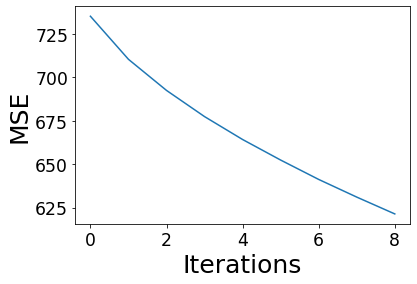

In [9]:

import matplotlib.pyplot as plt
fig,ax = plt.subplots()


ax.plot(optim.mse_error)

ax.tick_params(labelsize='xx-large')

ax.set_xlabel("Iterations",fontsize=25)
ax.set_ylabel("MSE",fontsize=25)

# ax.legend(fontsize='large')


In [ ]:
uid_dict = {}
sys.path.append("../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    #print(n)
    #print(rn.network.nodes()[n])
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_val = {'reactants':reactants,'kon':v['k_on'],'score':v['rxn_score'],'koff':v['k_off'],'uid':uid}
        if uid not in uid_dict.keys():
            uid_dict[uid] = uid_val
    print(gtostr(rn.network.nodes[n]['struct']))
    #for r_set in rn.get_reactant_sets(n):
    #    print(tuple(r_set))
    #print(rn.network[n]['struct'])
ind_sort = np.argsort(vec_rn.kon.detach().numpy())
for i in ind_sort:
    print(vec_rn.kon[i])
    print(uid_dict[i])

## Get all the parameter values

### This can be stored in a file for later analysis or used to find the best parameter value depending upon a condition. For e.g. the values that give a minimum error.

In [27]:
yields= []
final_params=[]
for i in range(len(optim.final_yields)):
    yields.append(optim.final_yields[i].item())
#     print(optim.final_solns[i].numpy())
    final_params.append(optim.final_solns[i].numpy())

sort_indx=np.argsort(np.array(yields))
sorted_yields=np.array(yields)#[sort_indx]
sorted_params = np.array(final_params)#[sort_indx]


print(sorted_params[-1])

[1.42763576 1.42763576 1.42763576 1.44407617 1.44407617 1.44407617]


### Can also plot the yield at the sim_runtime over all optim iterations

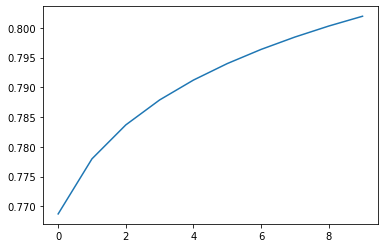

In [28]:
optim.plot_yield()